In [1]:
from yugiquery import *
header('Timeline')

<div align='center'>
    <br>
    <!-- Pre Style needed to fix HTML formatting -->
    <pre style="line-height: var(--jp-code-line-height); font-family: var(--jp-code-font-family)">
    ██    ██ ██    ██  ██████  ██  ██████  ██    ██ ███████ ██████  ██    ██ 
     ██  ██  ██    ██ ██       ██ ██    ██ ██    ██ ██      ██   ██  ██  ██  
      ████   ██    ██ ██   ███ ██ ██    ██ ██    ██ █████   ██████    ████   
       ██    ██    ██ ██    ██ ██ ██ ▄▄ ██ ██    ██ ██      ██   ██    ██    
       ██     ██████   ██████  ██  ██████   ██████  ███████ ██   ██    ██    
                                      ▀▀                                     
    </pre>
</div>
<div align='right'>
    Timeline - Execution started 11/02/2023 18:51 UTC <br>
    By <b>Guilherme Ruiz</b>
</div>

---

Table of Contents
=================

*   [1  Data preparation](#Data-preparation)
    *   [1.1  Load data](#Load-data)
    *   [1.2  Format data](#Format-data)
    *   [1.3  Merge data](#Merge-data)
*   [4  Data visualization](#Data-visualization)
    *   [4.1  First releases](#First-releases)
        *   [4.1.1  By region](#By-region)
    *   [4.1  Last releases](#Last-releases)
        *   [4.1.1  By region](#By-region)
    *   [4.2  All Releases](#All-Releases)
        *   [4.2.1  By card type](#By-card-type)
        *   [4.2.2  By primary type](#By-primary-type)
        *   [4.2.3  By secondary type](#By-secondary-type)
        *   [4.2.4  By attribute](#By-attribute)
        *   [4.2.5  By monster type](#By-monster-type)
        *   [4.2.6  By Level/Rank](#By-Level/Rank)
        *   [4.2.7  By ATK](#By-ATK)
        *   [4.2.8  By DEF](#By-DEF)
        *   [4.2.9  By pendulum scale](#By-pendulum-scale)
        *   [4.2.10  By link](#By-link)
*   [5  Debug](#Debug)
    *   [5.1  Merge failed](#Merge-failed)
*   [6  Epilogue](#Epilogue)
    *   [6.1  HTML export](#HTML-export)
<!-- *   [6.2  Git](#Git) -->

# Data preparation

## Load data

In [2]:
# Load list of important dates
dates_df = pd.read_json('../assets/dates.json', orient='index').sort_values(['type','begin','end'])
dates_df = dates_df.applymap(pd.to_datetime, errors='ignore', dayfirst=True)
anime_df = dates_df[dates_df['type']=='series']
rules_df = dates_df[dates_df['type']=='rules'][2:] # Ignore old rules
dates_df

type      begin        end
Master Rules 5      rules 2020-04-01        NaT
New Expert Rules    rules 2000-03-02 2008-03-14
Expert Rules        rules 1999-05-05 2000-03-01
Master Rules 1      rules 2008-03-15 2011-03-18
Master Rules 2      rules 2011-03-19 2014-03-20
Master Rules 3      rules 2014-03-21 2017-03-24
Official Rules      rules 1999-01-23 2000-03-01
Master Rules 4      rules 2017-03-25 2020-03-31
5D's               series 2008-04-02 2011-03-30
GO RUSH!!          series 2022-04-03        NaT
First Series       series 1998-04-04 1998-10-10
SEVENS             series 2020-04-04 2022-03-27
ARC-V              series 2014-04-06 2017-03-26
GX                 series 2004-10-06 2008-03-26
VRAINS             series 2017-03-10 2019-11-05
ZEXAL              series 2011-04-11 2014-03-23
Duel Monsters      series 2000-04-18 2004-09-29
Capsule Monsters  spinoff 2006-11-09 2006-11-25

In [3]:
# Get list of files
all_cards_files = sorted(glob.glob('../data/all_cards_*.csv'), key=os.path.getctime, reverse=True)
set_lists_files = sorted(glob.glob('../data/all_sets_*.csv'), key=os.path.getctime, reverse=True)
# Get newest file if exist
if len(all_cards_files)>0:
    all_cards_df = pd.read_csv(all_cards_files[0], dtype=object)
    # Correct tuples
    all_cards_df['Effect type'] = all_cards_df['Effect type'].dropna().apply(literal_eval)
    all_cards_df['Link Arrows'] = all_cards_df['Link Arrows'].dropna().apply(literal_eval)
    all_cards_df['Archseries'] = all_cards_df['Archseries'].dropna().apply(literal_eval)
    all_cards_df['Artwork'] = all_cards_df['Artwork'].dropna().apply(literal_eval)
    all_cards_df['Errata'] = all_cards_df['Errata'].dropna().apply(literal_eval)
    print('Cards file loaded')
else:
    all_cards_df = None
    print('No cards files')
    
if len(set_lists_files)>0:
    set_lists_df = pd.read_csv(set_lists_files[0], dtype=object)
    # Correct tuples
    set_lists_df['Rarity'] = set_lists_df['Rarity'].dropna().apply(literal_eval)
    set_lists_df['Cover card'] = set_lists_df['Cover card'].dropna().apply(literal_eval)
    print('Sets file loaded')
else:
    set_lists_df = None
    print('No set lists files')

Cards file loaded
Sets file loaded


## Format data

In [4]:
if all_cards_df is not None and set_lists_df is not None:
    all_cards_df['index'] = all_cards_df['Name'].str.lower()
    set_lists_df['index'] = set_lists_df['Name'].str.lower()
    all_cards_df['Modification date'] = pd.to_datetime(all_cards_df['Modification date'])
    set_lists_df['Modification date'] = pd.to_datetime(set_lists_df['Modification date'])
    set_lists_df['Release'] = pd.to_datetime(set_lists_df['Release'])
    
else:
    raise SystemExit("Not enough files to proceed. Aborting!")

## Merge data

In [5]:
full_df = all_cards_df.merge(set_lists_df, indicator = True, how='outer', on='index')
full_df = full_df.convert_dtypes()
full_df['Modification date'] = full_df[['Modification date_x','Modification date_y']].max(axis=1)
full_df['Name'] = full_df['Name_x'].fillna(full_df['Name_y'])
full_df.drop(['index', 'Name_x', 'Name_y', 'Modification date_x', 'Modification date_y'], axis=1, inplace = True)
full_df.rename(columns={'Page URL_x': 'Card page URL', 'Page URL_y': 'Set page URL'}, inplace=True)
full_df = full_df[np.append(full_df.columns[-1:],full_df.columns[:-1])]

# Data visualization

In [6]:
full_df

Name  Password   Card type  \
0               "A" Cell Breeding Device  34541863  Spell Card   
1               "A" Cell Breeding Device  34541863  Spell Card   
2               "A" Cell Breeding Device  34541863  Spell Card   
3               "A" Cell Breeding Device  34541863  Spell Card   
4               "A" Cell Breeding Device  34541863  Spell Card   
...                                  ...       ...         ...   
157769                 Magiquartet Shock      <NA>        <NA>   
157770                 Magiquartet Shock      <NA>        <NA>   
157771  Ultimate Flag Beast Surge Bicorn      <NA>        <NA>   
157772                   The Star Dragon      <NA>        <NA>   
157773                  Handsray Destleo      <NA>        <NA>   

                     Property        Effect type Archseries TCG status  \
0       Continuous Spell Card  (Trigger Effect,)        NaN  Unlimited   
1       Continuous Spell Card  (Trigger Effect,)        NaN  Unlimited   
2       Continuous Spell Card  (Trigger Effect,)        NaN  Unlimited   
3       Continuous Spell Card  (Trigger Effect,)        NaN  Unlimited   
4       Continuous Spell Card  (Trigger Effect,)        NaN  Unlimited   
...                       ...                ...        ...        ...   
157769                   <NA>                NaN        NaN       <NA>   
157770                   <NA>                NaN        NaN       <NA>   
157771                   <NA>                NaN        NaN       <NA>   
157772                   <NA>                NaN        NaN       <NA>   
157773                   <NA>                NaN        NaN       <NA>   

       OCG status Artwork                                      Card page URL  \
0       Unlimited     NaN  https://yugipedia.com/wiki/%22A%22_Cell_Breedi...   
1       Unlimited     NaN  https://yugipedia.com/wiki/%22A%22_Cell_Breedi...   
2       Unlimited     NaN  https://yugipedia.com/wiki/%22A%22_Cell_Breedi...   
3       Unlimited     NaN  https://yugipedia.com/wiki/%22A%22_Cell_Breedi...   
4       Unlimited     NaN  https://yugipedia.com/wiki/%22A%22_Cell_Breedi...   
...           ...     ...                                                ...   
157769       <NA>     NaN                                               <NA>   
157770       <NA>     NaN                                               <NA>   
157771       <NA>     NaN                                               <NA>   
157772       <NA>     NaN                                               <NA>   
157773       <NA>     NaN                                               <NA>   

         Errata Primary type Secondary type Attribute Monster type Level/Rank  \
0       (Name,)         <NA>           <NA>      <NA>         <NA>       <NA>   
1       (Name,)         <NA>           <NA>      <NA>         <NA>       <NA>   
2       (Name,)         <NA>           <NA>      <NA>         <NA>       <NA>   
3       (Name,)         <NA>           <NA>      <NA>         <NA>       <NA>   
4       (Name,)         <NA>           <NA>      <NA>         <NA>       <NA>   
...         ...          ...            ...       ...          ...        ...   
157769      NaN         <NA>           <NA>      <NA>         <NA>       <NA>   
157770      NaN         <NA>           <NA>      <NA>         <NA>       <NA>   
157771      NaN         <NA>           <NA>      <NA>         <NA>       <NA>   
157772      NaN         <NA>           <NA>      <NA>         <NA>       <NA>   
157773      NaN         <NA>           <NA>      <NA>         <NA>       <NA>   

         ATK   DEF Pendulum Scale  Link Link Arrows  \
0       <NA>  <NA>           <NA>  <NA>         NaN   
1       <NA>  <NA>           <NA>  <NA>         NaN   
2       <NA>  <NA>           <NA>  <NA>         NaN   
3       <NA>  <NA>           <NA>  <NA>         NaN   
4       <NA>  <NA>           <NA>  <NA>         NaN   
...      ...   ...            ...   ...         ...   
157769  <NA>  <NA>           <NA>  

## First releases

Obs: Only the first release of an individual card name

In [7]:
first_release=full_df[full_df['Release'].notna()].groupby('Name')['Release'].agg(['min','idxmin'])
first_release

min  idxmin
Name                                            
"A Legendary Ocean"           2005-07-27  155891
"A" Cell Breeding Device      2007-02-15       0
"A" Cell Incubator            2007-07-21      12
"A" Cell Recombination Device 2016-07-09      19
"A" Cell Scatter Burst        2006-11-16      28
...                                  ...     ...
Zubaba General                2012-12-22  155224
Zubaba Knight                 2011-03-19  155256
Zubababancho Gagagacoat       2019-11-09  155276
Zure, Knight of Dark World    2005-08-11  155292
Zushin the Sleeping Giant     2016-05-14  155310

[12486 rows x 2 columns]

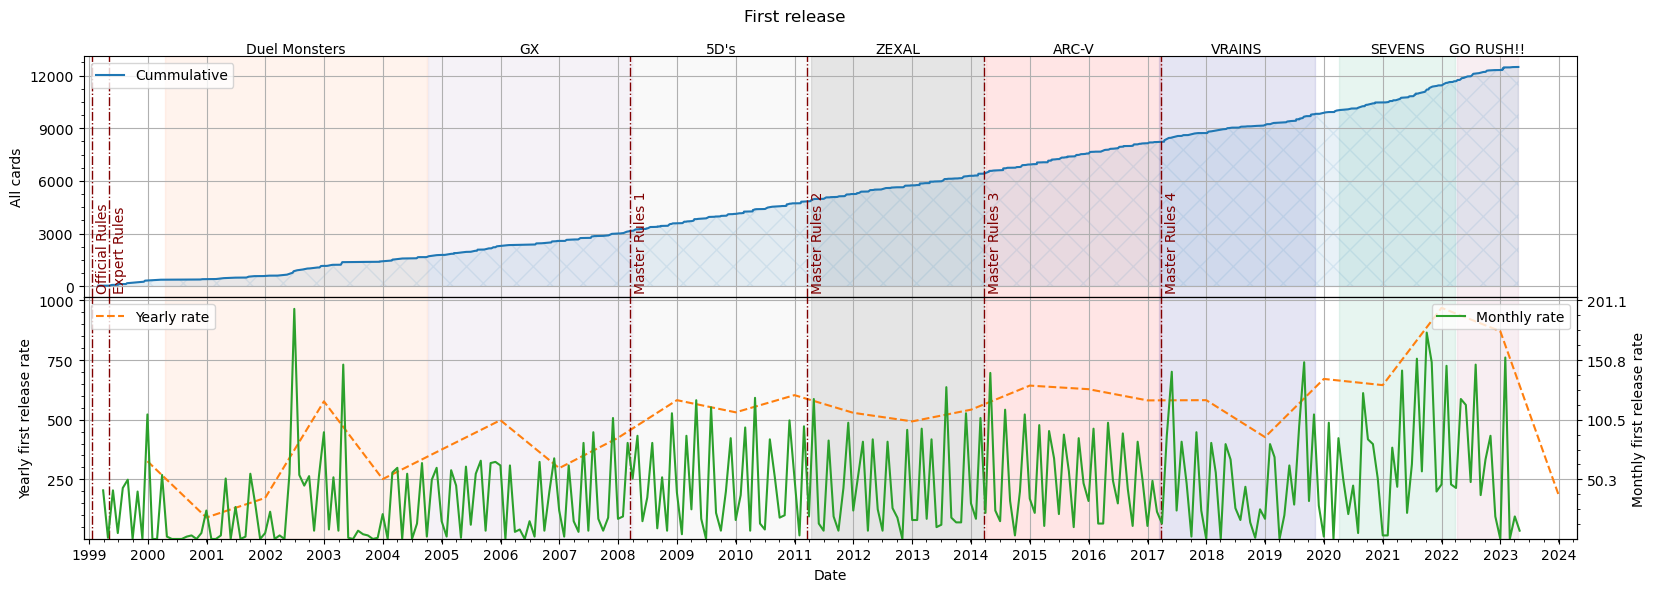

In [8]:
first_release_count = first_release['min'].sort_values().value_counts(sort=False).to_frame(name='All cards')
first_release_count.index.name = 'First Release'
rate_plot(first_release_count, bg=anime_df, vlines = rules_df['begin'])


### By region

In [9]:
first_release_region=full_df[full_df['Release'].notna()].groupby(['Region','Name'])['Release'].agg(['min','idxmin'])
first_release_region

min  idxmin
Region Name                                         
AE     3-Hump Lacooda             2004-10-14      87
       7                          2004-10-14     126
       7 Colored Fish             2002-10-24     154
       8-Claws Scorpion           2003-10-23     177
       A Cat of Ill Omen          2003-10-23     186
...                                      ...     ...
TC     ZW - Lightning Blade       2015-12-05  154273
       ZW - Tornado Bringer       2015-12-05  154312
       ZW - Ultimate Shield       2015-12-05  154321
       Zerozerock                 2015-12-05  154701
       Zure, Knight of Dark World 2015-03-01  155298

[84328 rows x 2 columns]

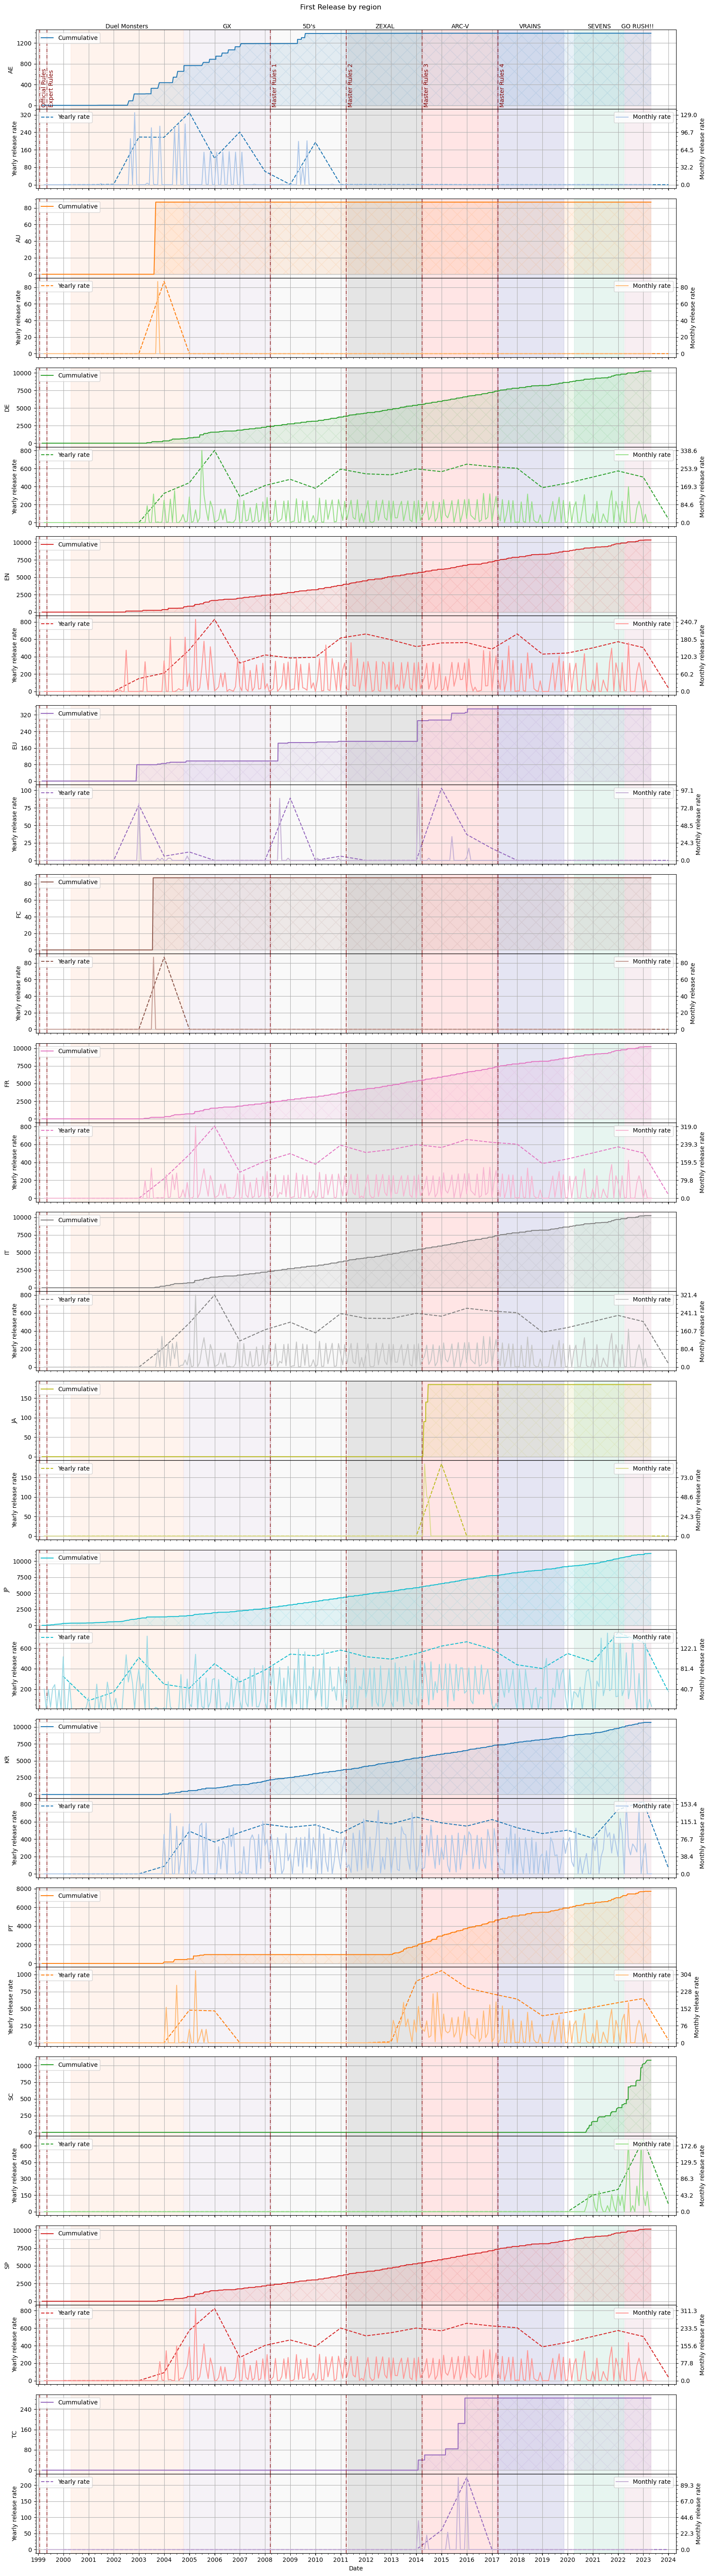

In [10]:
first_release_region_count = first_release_region['min'].sort_values().groupby(['Region']).value_counts(sort=False).unstack(0).fillna(0).round(0)
first_release_region_count.index.name = 'Release'
rate_subplots(first_release_region_count, title = 'First Release', bg=anime_df, vlines = rules_df['begin'])

## Last releases

Obs: Only the last release of an individual card name

In [11]:
last_release=full_df[full_df['Release'].notna()].groupby('Name')['Release'].agg(['max','idxmax'])
last_release

max  idxmax
Name                                            
"A Legendary Ocean"           2005-07-27  155891
"A" Cell Breeding Device      2014-03-26       7
"A" Cell Incubator            2012-05-12      17
"A" Cell Recombination Device 2016-11-04      23
"A" Cell Scatter Burst        2014-03-26      33
...                                  ...     ...
Zubaba General                2016-02-12  155217
Zubaba Knight                 2013-11-25  155232
Zubababancho Gagagacoat       2020-02-05  155277
Zure, Knight of Dark World    2018-06-30  155303
Zushin the Sleeping Giant     2020-09-10  155312

[12486 rows x 2 columns]

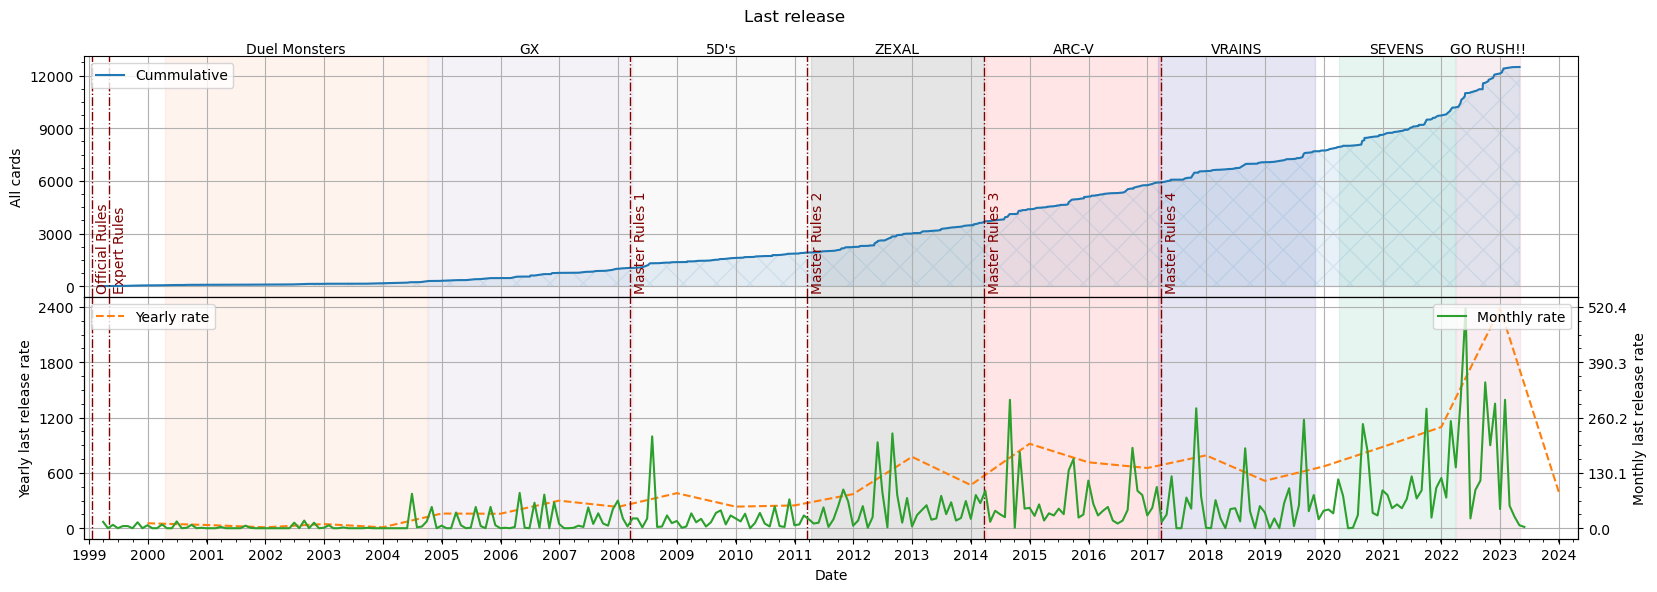

In [12]:
last_release_count = last_release['max'].sort_values().value_counts(sort=False).to_frame(name='All cards')
last_release_count.index.name = 'Last Release'
rate_plot(last_release_count, bg=anime_df, vlines = rules_df['begin'])

### By region

In [13]:
last_release_region=full_df[full_df['Release'].notna()].groupby(['Region','Name'])['Release'].agg(['max','idxmax'])
last_release_region

max  idxmax
Region Name                                         
AE     3-Hump Lacooda             2004-10-14      87
       7                          2004-10-14     126
       7 Colored Fish             2002-10-24     154
       8-Claws Scorpion           2003-10-23     177
       A Cat of Ill Omen          2003-10-23     186
...                                      ...     ...
TC     ZW - Lightning Blade       2015-12-05  154273
       ZW - Tornado Bringer       2015-12-05  154312
       ZW - Ultimate Shield       2015-12-05  154321
       Zerozerock                 2015-12-05  154701
       Zure, Knight of Dark World 2015-03-01  155298

[84328 rows x 2 columns]

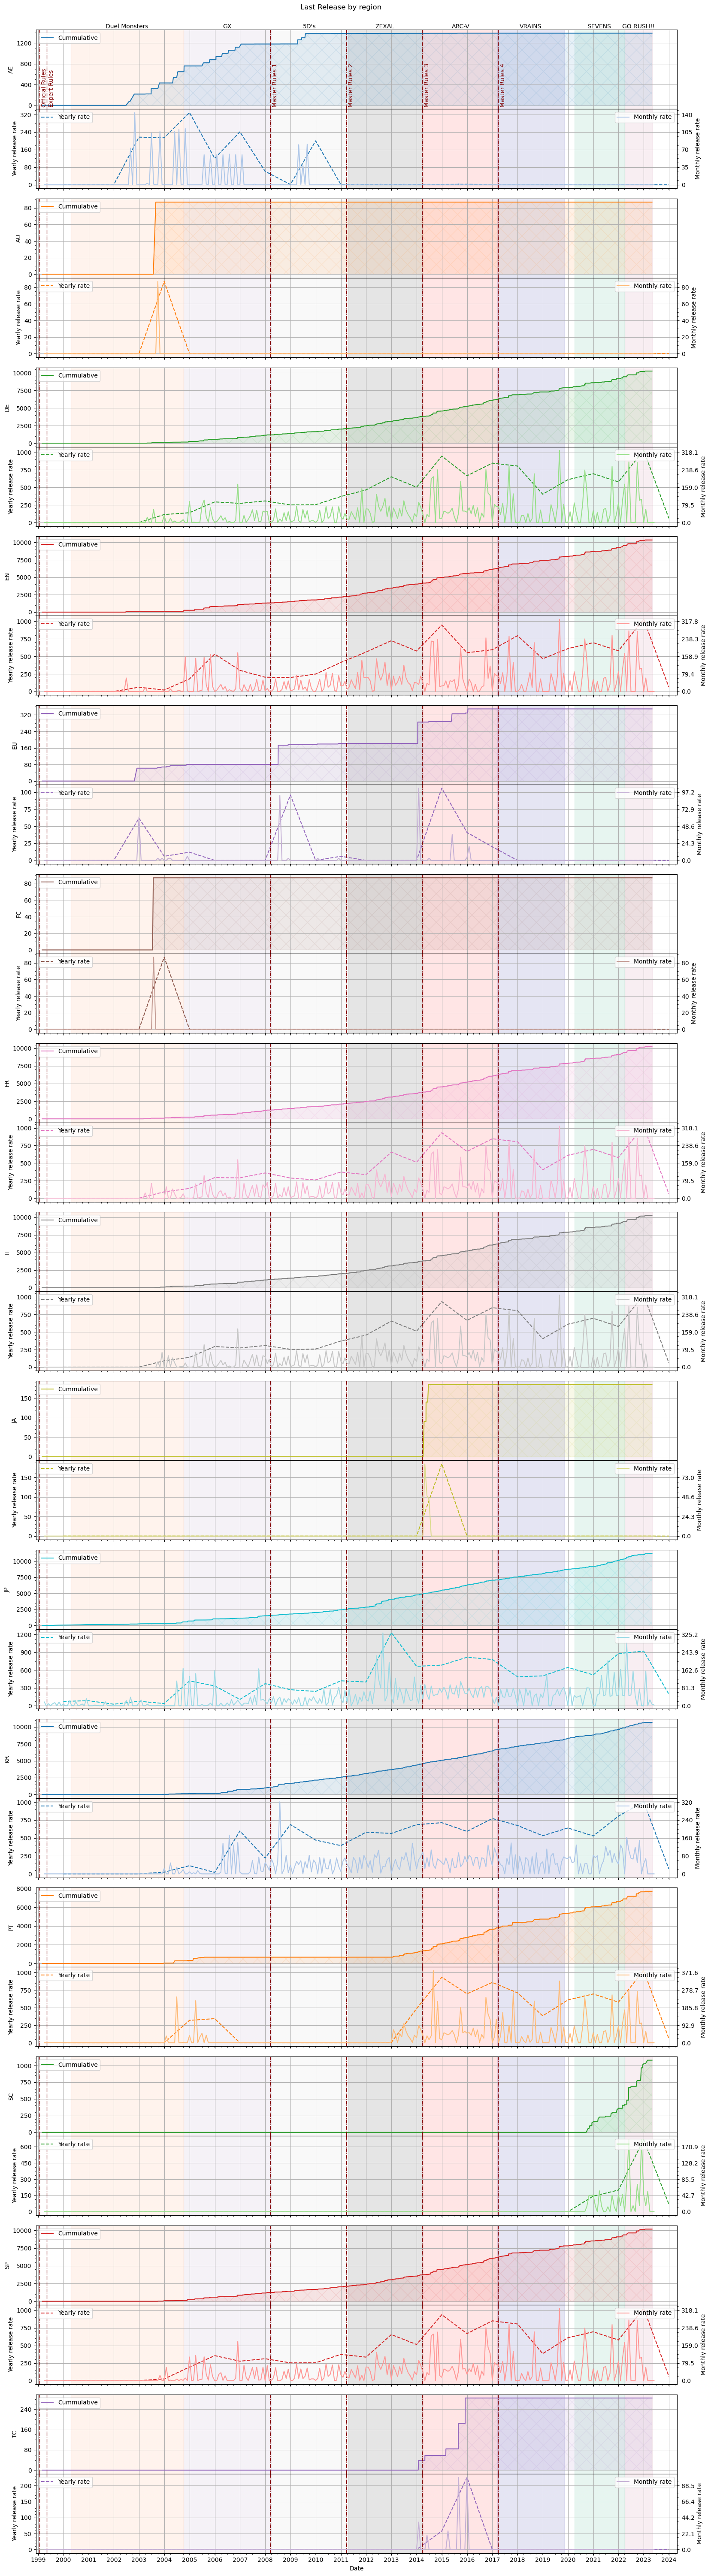

In [14]:
last_release_region_count = last_release_region['max'].sort_values().groupby(['Region']).value_counts(sort=False).unstack(0).fillna(0).round(0)
last_release_region_count.index.name = 'Release'
rate_subplots(last_release_region_count, title = 'Last Release', bg=anime_df, vlines = rules_df['begin'])

## All Releases

Obs: All releases includes reprints

### By card type

In [15]:
# All releases, includes reprints - Double check
release_card_type = full_df.groupby(['Card type','Release'])['Name'].nunique().unstack(0).sort_index().fillna(0).astype(int)
release_card_type.groupby(release_card_type.index.strftime('%Y')).sum().T

Release       1999  2000  2001  2002  2003  2004  2005  2006  2007  2008  \
Card type                                                                  
Counter          0     0     0     0     0     0     0     0     0     0   
Monster Card   282   230   195   765  1433  2672  2246  1734  1898  1945   
Spell Card      47    68    68   280   474  1126   939   735   783   704   
Trap Card       21    26    44   152   355   830   707   569   654   596   

Release       2009  2010  2011  2012  2013  2014  2015  2016  2017  2018  \
Card type                                                                  
Counter          0     0     0     0     0     1     2     1     1     0   
Monster Card  1775  2195  2605  3591  3067  3773  3120  3014  2169  1353   
Spell Card     632   577   718  1029   766  1044   961   984   653   478   
Trap Card      555   547   623   799   623   871   729   745   496   295   

Release       2019  2020  2021  2022  2023  
Card type                                   
Counter          1     0     0     0     0  
Monster Card  1702  1251  1289  1961   156  
Spell Card     604   453   529   662    72  
Trap Card      359   246   250   315    26

In [16]:
# card_type_colors = [colors_dict[col] for col in release_card_type.columns]
# rate_subplots(release_card_type, colors=card_type_colors, bg=anime_df, vlines = rules_df['begin'])

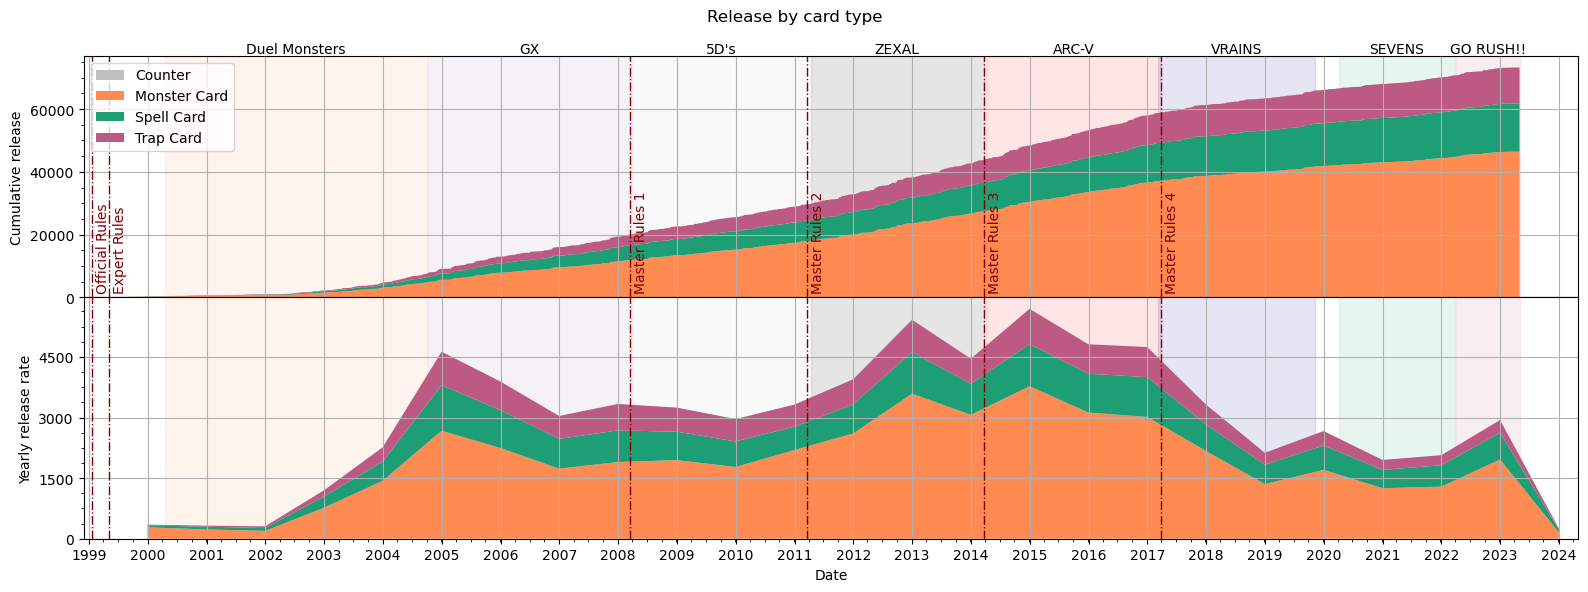

In [17]:
card_type_colors = [colors_dict[col] for col in release_card_type.columns]
rate_plot(release_card_type, colors=card_type_colors, bg=anime_df, vlines = rules_df['begin'])

### By primary type

In [18]:
# All releases, includes reprints - Double check
# Sort properly
release_primary_type = full_df.groupby(['Primary type','Release'])['Name'].nunique().unstack(0).sort_index().fillna(0).astype(int)
release_primary_type.groupby(release_primary_type.index.strftime('%Y')).sum().T

Release          1999  2000  2001  2002  2003  2004  2005  2006  2007  2008  \
Primary type                                                                  
Effect Monster     42    47    93   361   722  1660  1779  1346  1555  1594   
Fusion Monster     18    16    17    49    75   120   112   135   181   108   
Link Monster        0     0     0     0     0     0     0     0     0     0   
Monster Token       0     0     0     0     0     0     0     0     2     0   
Normal Monster    220   162    83   346   625   865   330   232   146   148   
Ritual Monster      2     9     2    10    11    31    26    21    14    11   
Synchro Monster     0     0     0     0     0     0     0     0     0    85   
Xyz Monster         0     0     0     0     0     0     0     0     0     0   

Release          2009  2010  2011  2012  2013  2014  2015  2016  2017  2018  \
Primary type                                                                  
Effect Monster   1506  1758  2051  2756  2237  2804  2154  2128  1530   826   
Fusion Monster     32    62   142   106    34   125   196   222   155    56   
Link Monster        0     0     0     0     0     0     0     0   100   257   
Monster Token       1     2     2     2     6     4     2    13     2     2   
Normal Monster     75   113   103   192   132   138   282   212    80    61   
Ritual Monster      7    14    11    32    17    20    70    40    29    57   
Synchro Monster   154   248   207   168   108   247   193   162   113    55   
Xyz Monster         0     0    90   338   533   436   231   238   160    39   

Release          2019  2020  2021  2022  2023  
Primary type                                   
Effect Monster   1085   763   838  1252    81  
Fusion Monster     92    83    70   154    12  
Link Monster      279   161    77   109     8  
Monster Token       1     1     5     5     0  
Normal Monster     25    64    66   116    11  
Ritual Monster     45    38    25    37    13  
Synchro Monster    85    53   100   153    14  
Xyz Monster        90    91   108   135    18

In [19]:
# primary_type_colors = [colors_dict[col] for col in release_primary_type.columns]
# rate_subplots(release_primary_type, colors=primary_type_colors, bg=anime_df, vlines=rules_df['begin'])

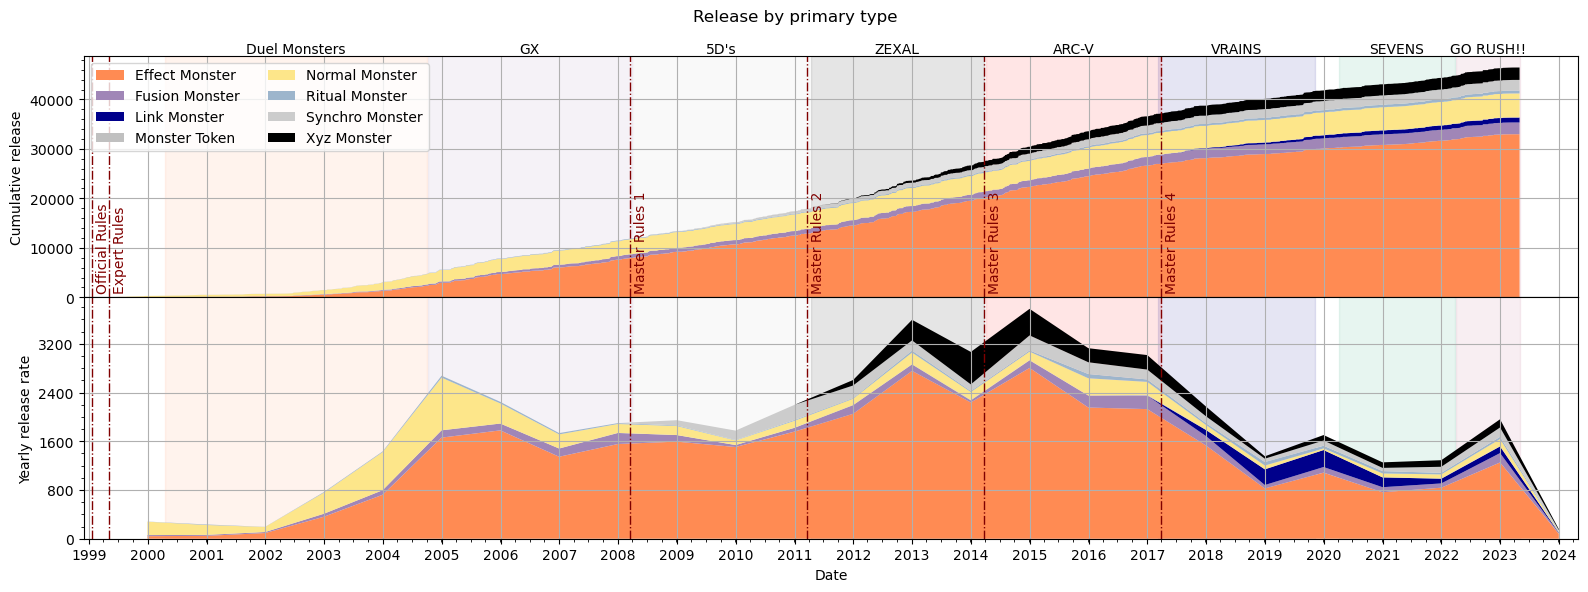

In [20]:
primary_type_colors = [colors_dict[col] for col in release_primary_type.columns]
rate_plot(release_primary_type, colors=primary_type_colors, bg=anime_df, vlines = rules_df['begin'])

### By secondary type

In [21]:
# All releases, includes reprints - Double check
# Sort properly
release_secondary_type = full_df.groupby(['Secondary type','Release'])['Name'].nunique().unstack(0).sort_index().fillna(0).astype(int)
release_secondary_type.groupby(release_secondary_type.index.strftime('%Y')).sum().T

Release                             1999  2000  2001  2002  2003  2004  2005  \
Secondary type                                                                 
('Flip monster', 'Tuner monster')      0     0     0     0     0     0     0   
('Flip monster',)                     10    13    17    64   113   232   133   
('Gemini monster',)                    0     0     0     0     0     0     0   
('Spirit monster',)                    0     0     0     0    15    14    30   
('Toon monster',)                      0     0     0     4     8    38    10   
('Tuner monster', 'Union monster')     0     0     0     0     0     0     0   
('Tuner monster',)                     0     0     0     0     0     0     0   
('Union monster',)                     0     0     0    10     4    15    51   

Release                             2006  2007  2008  2009  2010  2011  2012  \
Secondary type                                                                 
('Flip monster', 'Tuner monster')      0     0     0     0     0     0     0   
('Flip monster',)                     94    55    83    51    59    61   113   
('Gemini monster',)                    0    70    23    21     1     7    33   
('Spirit monster',)                   14     8     9    16     5    11    16   
('Toon monster',)                      9     1     8     0     1     3    19   
('Tuner monster', 'Union monster')     0     0     0     0     0     0     0   
('Tuner monster',)                     0     0   101   189   329   297   185   
('Union monster',)                    25    20    10     5    23     9    19   

Release                             2013  2014  2015  2016  2017  2018  2019  \
Secondary type                                                                 
('Flip monster', 'Tuner monster')      0     4     2     6     2     0     1   
('Flip monster',)                     54    93    59    31    71    23    16   
('Gemini monster',)                   23    12    15    43     7     1     0   
('Spirit monster',)                   15     5     1    13    36    13     0   
('Toon monster',)                      3     3    24    21     6     0     2   
('Tuner monster', 'Union monster')     0     0     0     4     0     0     0   
('Tuner monster',)                   110   245   208   166   132    74    95   
('Union monster',)                     3     9     1    30     4     1     6   

Release                             2020  2021  2022  2023  
Secondary type                                              
('Flip monster', 'Tuner monster')      0     1     3     0  
('Flip monster',)                      9    17    19     0  
('Gemini monster',)                    2     3     1     1  
('Spirit monster',)                    0     3     7     2  
('Toon monster',)                      1     0     2     0  
('Tuner monster', 'Union monster')     0     0     0     0  
('Tuner monster',)                    82   120   193    13  
('Union monster',)                     6     2     4     0

In [22]:
# rate_subplots(release_secondary_type, bg=anime_df, vlines = rules_df['begin'])

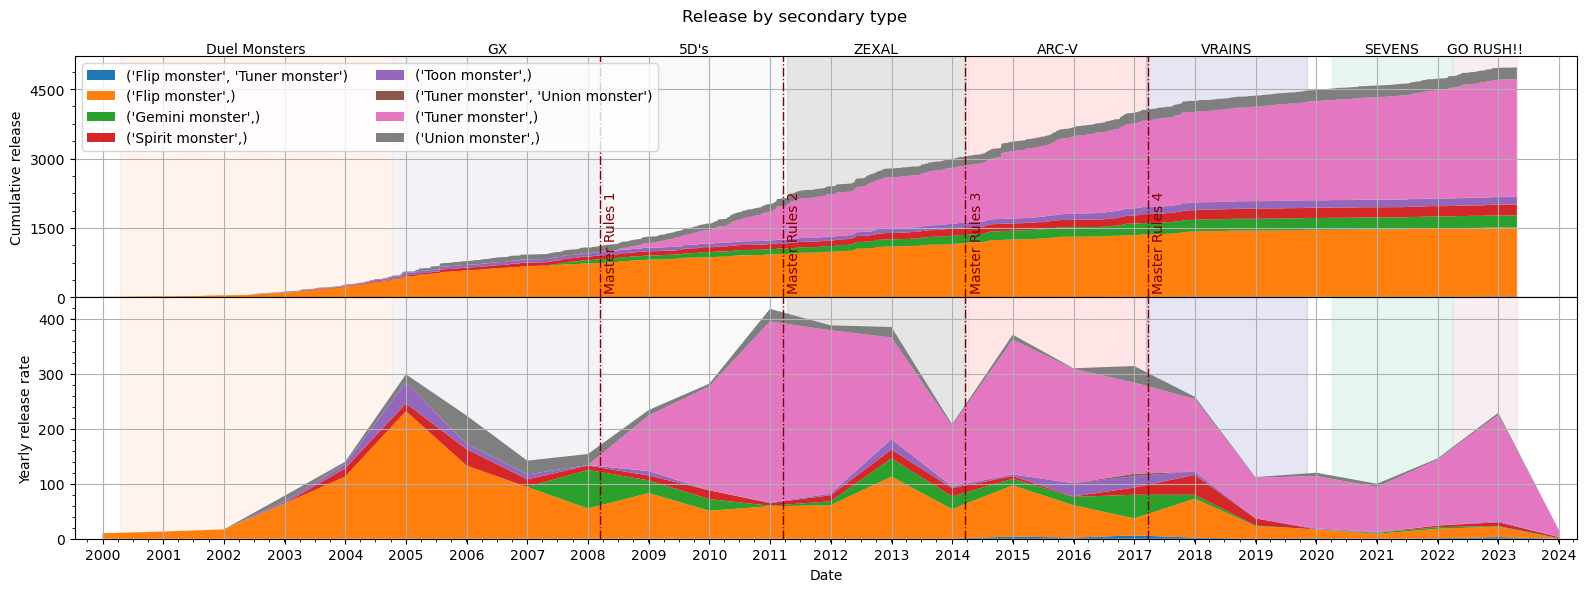

In [23]:
rate_plot(release_secondary_type, bg=anime_df, vlines = rules_df['begin'])

### By attribute

In [24]:
# All releases, includes reprints - Double check
# Sort properly
release_attribute = full_df.groupby(['Attribute','Release'])['Name'].nunique().unstack(0).sort_index().fillna(0).astype(int)
release_attribute.groupby(release_attribute.index.strftime('%Y')).sum().T

Release    1999  2000  2001  2002  2003  2004  2005  2006  2007  2008  2009  \
Attribute                                                                     
DARK         80    77    51   251   481   780   588   385   431   564   482   
DIVINE        0     3     0     0     3     1     1     0     0     4     1   
EARTH       102    82    69   233   463   756   646   495   463   469   476   
FIRE          9     5    11    37    69   188   175   155   179   138   152   
LIGHT        26    20    20   103   179   415   439   362   419   448   318   
WATER        44    27    18    69   117   267   215   140   231   145   161   
WIND         21    16    26    72   121   265   182   197   175   177   185   

Release    2010  2011  2012  2013  2014  2015  2016  2017  2018  2019  2020  \
Attribute                                                                     
DARK        558   679   864   726   981   917  1108   710   449   624   358   
DIVINE        9     5     7     6    17    15    16     7     0    11     6   
EARTH       620   602   834   601   996   662   593   494   211   284   254   
FIRE        139   227   305   386   263   267   206   123    88   123   108   
LIGHT       479   547   860   778   922   692   696   442   362   393   241   
WATER       136   236   473   295   275   264   231   199    71   122   179   
WIND        254   309   248   275   319   303   164   194   172   145   105   

Release    2021  2022  2023  
Attribute                    
DARK        320   650    50  
DIVINE        2     2     0  
EARTH       174   372    26  
FIRE        105   125    19  
LIGHT       282   365    47  
WATER       205   227     9  
WIND        201   220     5

In [25]:
# attribute_colors = [colors_dict[col] for col in release_attribute.columns]
# rate_subplots(release_attribute, colors=attribute_colors, bg=anime_df, vlines = rules_df['begin'])

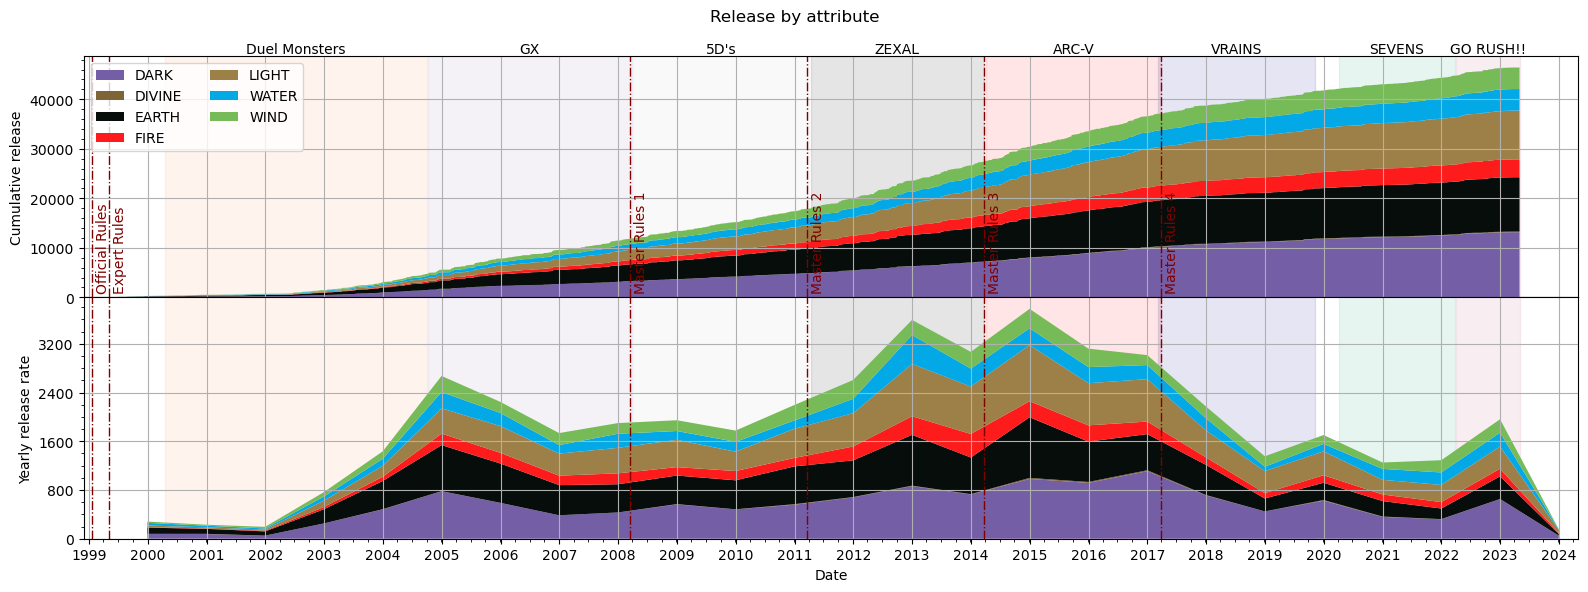

In [26]:
attribute_colors = [colors_dict[col] for col in release_attribute.columns]
rate_plot(release_attribute, colors = attribute_colors, bg=anime_df, vlines = rules_df['begin'], cumsum=True)

### By monster type

In [27]:
# All releases, includes reprints - Double check
# Sort properly
release_monster_type = full_df.groupby(['Monster type','Release'])['Name'].nunique().unstack(0).sort_index().fillna(0).astype(int)
release_monster_type.groupby(release_monster_type.index.strftime('%Y')).sum().T

Release        1999  2000  2001  2002  2003  2004  2005  2006  2007  2008  \
Monster type                                                                
Aqua             26    15    12    45    70   138    79    55    60    45   
Beast            20    14     8    44    94   147   158    91    97    72   
Beast-Warrior    11    10     8    25    52    67    63    44    50    31   
Creator God       0     0     0     0     0     0     0     0     0     0   
Cyberse           0     0     0     0     0     0     0     0     0     0   
Dinosaur          7     8     3    13    19    46    39    51    36    32   
Divine-Beast      0     3     0     0     3     1     1     0     0     4   
Dragon           16    17    22    50    73   159    95    75   105   139   
Fairy            12     7    12    30    66   166   133   127   171   128   
Fiend            39    42    31   104   233   368   265   173   217   179   
Fish              8     4     4    13    27    51    28    15    24    31   
Insect           14    12     8    39    71   139    74    75    55    67   
Machine          14     7     9    59    84   169   254   212   244   242   
Plant             8     3     4    11    13    40    35    23    33    61   
Psychic           0     0     0     0     0     0     0     0     0    43   
Pyro              3     1     2    13    27    85    72    50    65    39   
Reptile           5     2     2     9    24    51    41    28    79    36   
Rock             10    11     9    22    51    85   112    94    55    66   
Sea Serpent       2     1     1     4     4    14    27    12    17    15   
Spellcaster      27    22    15   109   183   330   249   159   126   183   
Thunder           2     3     1    19    31    48    36    34    30    44   
Warrior          33    32    36   100   202   374   342   311   332   347   
Winged Beast     10     7     6    27    38    97    45    65    61    71   
Wyrm              0     0     0     0     0     0     0     0     0     0   
Zombie           15     9     2    29    68    97    98    40    41    70   

Release        2009  2010  2011  2012  2013  2014  2015  2016  2017  2018  \
Monster type                                                                
Aqua             43    38    77   156    72    81    77    58    38    21   
Beast            79   141   154   166   153   217   124   118    73    45   
Beast-Warrior    48    47    56    84   206   137    75   102    98    29   
Creator God       0     0     1     0     0     0     0     0     0     0   
Cyberse           0     0     0     0     0     0     0     0    60   123   
Dinosaur         27    29    63    63    31    52    12    19    44    11   
Divine-Beast      1     9     4     7     6    17    15    16     7     0   
Dragon          162   221   229   338   323   284   327   412   224   141   
Fairy            57    98   199   153   141   251   190   148   141   107   
Fiend           128   210   264   259   243   308   418   290   229    95   
Fish             26    13    42    72    90    66    22    11    24     3   
Insect           71    74    60   112    54    77    37    65    74    19   
Machine         212   340   262   364   376   538   385   418   269   149   
Plant            69    77    64    58    69   174    58    53    61    19   
Psychic          42    34    66    49    49    60    99    85    57    54   
Pyro             25    45    64    94    67    53    31    14     8    13   
Reptile          62    74    58   100    40    36    31    23     7    10   
Rock             56    48    56   159   107   152    84   109    37     7   
Sea Serpent      39    23    24   121    49    30    25    14    15     3   
Spellcaster     190   147   145   341   261   295   340   346   233   119   
Thunder          20    78    44    72    39    45    36    21    26    16   
Warrior         265   286   476   652   448   540   462   428   231   192   
Winged Beast    101   133   167   103   152   207   155   154    96    5

In [ ]:
rate_subplots(release_monster_type, bg=anime_df, vlines = rules_df['begin'])

### By Level/Rank

In [ ]:
# Testing
def boxplot(df):
    col = df.columns[0]
    df['Year'] = df.index.strftime('%Y')
    df.dropna(inplace=True)

    ax = df.boxplot(by='Year', figsize=(16,10))

    mean = df.groupby('Year').mean()

    ax.plot(list(range(1,len(mean.index)+1)), mean.values, c='r', ls='--', alpha=0.5)
    
    ticks = np.arange(0,df[col].max()+1,1)
    if len(ticks)>15:
        ax.yaxis.set_major_locator(MaxNLocator(11, integer=True))
        ax.yaxis.set_minor_locator(AutoMinorLocator())
    else:
        ax.yaxis.set_major_locator(FixedLocator(ticks))
        
    # ax.set_ylim([0,5000])
    plt.tight_layout()
    plt.show()

In [ ]:
level_box = pd.to_numeric(full_df.set_index('Release')['Level/Rank'], errors='coerce').to_frame().sort_index().dropna()
boxplot(level_box)

### By ATK

In [ ]:
atk_box = pd.to_numeric(full_df.set_index('Release')['ATK'], errors='coerce').to_frame().sort_index().dropna()
boxplot(atk_box)

### By DEF

In [ ]:
def_box = pd.to_numeric(full_df.set_index('Release')['DEF'], errors='coerce').to_frame().sort_index().dropna()
boxplot(def_box)

### By pendulum scale

In [ ]:
pendulum_box = pd.to_numeric(full_df.set_index('Release')['Pendulum Scale'], errors='coerce').to_frame().sort_index().dropna()
boxplot(pendulum_box)

### By link

In [ ]:
link_box = pd.to_numeric(full_df.set_index('Release')['Link'], errors='coerce').to_frame().sort_index().dropna()
boxplot(link_box)

# Debug

## Merge failed

In [ ]:
full_df['_merge'].value_counts()

In [ ]:
full_df.where(full_df['_merge']=='right_only').dropna(axis=0,how='all')

In [ ]:
full_df.where(full_df['_merge']=='left_only').dropna(axis=0,how='all')

 # Epilogue

In [ ]:
footer()

## HTML export

In [ ]:
# May need to sleep for a few seconds after saving
save_notebook()

In [ ]:
! jupyter nbconvert Timeline.ipynb --output-dir='../' --to=HTML --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags='exclude' --TemplateExporter.exclude_input=True --TemplateExporter.exclude_input_prompt=True --TemplateExporter.exclude_output_prompt=True

## Git

In [ ]:
! git add "../*[Tt]imeline*"

In [ ]:
! git commit -m {"'Timeline update-" + pd.Timestamp.now().strftime("%d%m%Y")+"'"}